# Перенос обучения в задаче определения типа сцены из набора данных [Intel Image Classification](https://www.kaggle.com/puneet6060/intel-image-classification)

Созыкин Андрей

Бахарев С.М.

**Задача:**
Определить один из типов сцены на изображении: горы, лес, город,..., с использованием предобученной модели VGG16.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline

## Загружаем данные

In [ ]:
!wget https://www.dropbox.com/s/pnq8ej5c9ti1se7/intel_scene.zip?dl=1 -O intel_scene.zip

In [ ]:
!unzip intel_scene.zip

In [ ]:
!ls seg_train/seg_train

**Набор данных для обучения**

In [ ]:
train_dataset = image_dataset_from_directory('seg_train/seg_train',
                                             subset='training',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=128,
                                             image_size=(128, 128))

In [ ]:
validation_dataset = ...

Выведете названия классов в отдельную переменную

In [ ]:
class_names = ...
class_names

 Выведите на экран несколько изображений и их метки (class_names)

In [ ]:
 ...

**Набор данных для тестирования**

In [ ]:
test_dataset = image_dataset_from_directory('seg_test/seg_test',
                                             shuffle=True,
                                             label_mode='int',
                                             batch_size=128,
                                             image_size=(128, 128))

In [ ]:
test_dataset.class_names

### AUTOTUNE
позволяет автоматически настраивать уровень параллелизма для загрузки и предварительной обработки данных.

Основные сценарии использования:
1. Параллельная загрузка данных

- dataset.map() (параллельная обработка преобразований)

- dataset.prefetch() (перекрытие предобработки данных и выполнения модели)

- dataset.interleave() (параллельное чтение файлов)

2. Предварительная выборка (prefetch) – Позволяет TensorFlow автоматически определять, сколько батчей загружать заранее, чтобы совмещать предобработку и обучение.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Создаем нейронную сеть

Для распознавания сцены на изображении будем использовать предобученную модель VGG16. Это нейросеть для выделения признаков изображений.
Подробнее https://keras.io/api/applications/vgg/, https://neurohive.io/ru/vidy-nejrosetej/vgg16-model/

VGG16 обучена на ImageNet — набор данных, состоящий из более чем 15 миллионов размеченных высококачественных изображений, разделенных на 22000 категорий. Изображения были взяты из интернета и размечены вручную людьми-разметчиками.

Архитектура VGG16

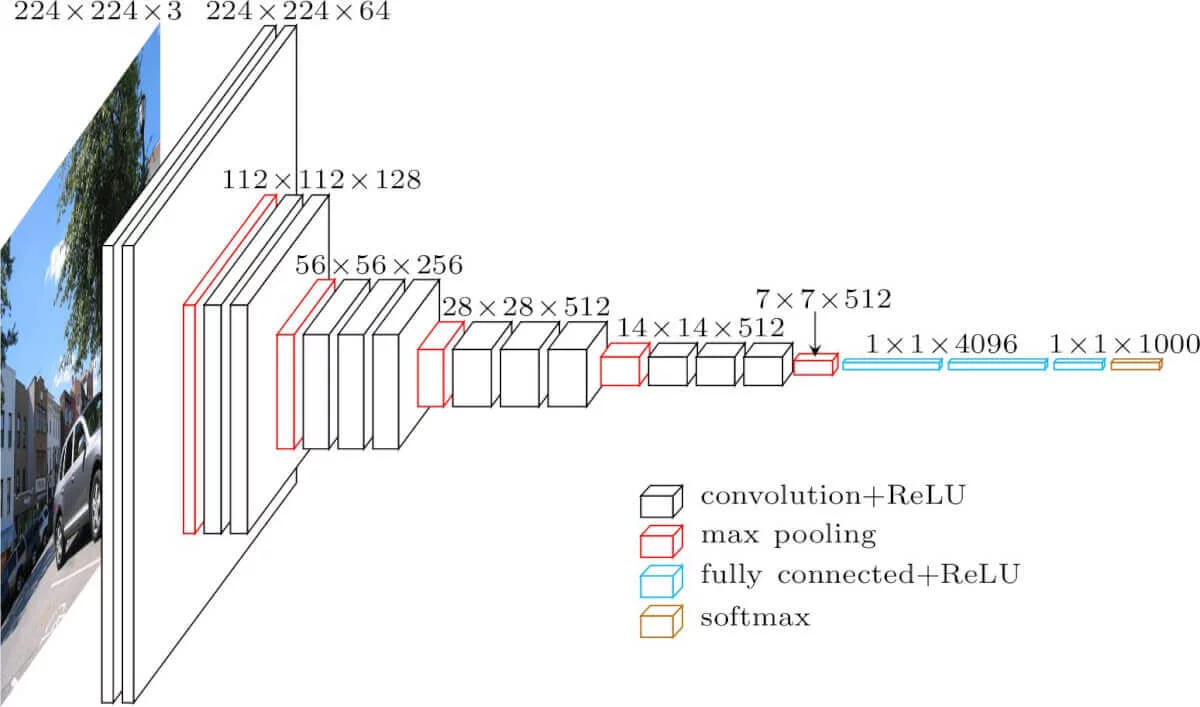

In [ ]:
vgg16_net = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))

Фиксируем веса, т.к. стоит задача переноса обучения.

In [ ]:
vgg16_net.trainable = False

**Придумайте архитектуру НС**

In [ ]:
model = Sequential()
model.add(Normalization())
# Добавьте модель VGG16 в сеть как слой
...
# Flatten, Полносвязный слой,
...
# Выходящий слой
...



**Скомпилируйте модель**

In [ ]:
...

### Обучение нейронной сети

In [ ]:
# Количество эпох для начала возьмите 3
...

### Оценка качества обучения сети

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

**Получите метрики качества (accuracy, precision, recall, F1_score) вашей классификации, постройте матрицу спутанности.**

In [ ]:
...

## Тонкая настройка нейронной сети

In [ ]:
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=3)

## Оцениваем качетсво обучения сети

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()